In [60]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import wikipedia as wp
import yfinance as yf
from ta.momentum import rsi
from ta.trend import macd
from ta.volatility import bollinger_hband_indicator, bollinger_lband_indicator

# Data collection and preprocessing
The first step of the project is to collect the S&P100 stocks and their historical values. The S&P100 is a stock market index made up of 100 major companies in the United States that are listed on the NYSE or NASDAQ. The index is a subset of the S&P 500 and is used as a benchmark for the US stock market.
The data is first collected then normalized.

## S&P100 stocks
The Wikipedia page is used to retrieve the S&P100 stocks list.
Notes:
- Alphabet Inc. (Google) is listed twice in the table due to the two different classes of shares. GOOGL is kept, as the oldest class of shares, and GOOG is deleted.
- Berkshire Hathaway is listed as BRK-B on yahoo! finance, while being listed BRK.B on the wikipedia page. The symbol is changed in this list to the yfinance value.

In [2]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head()

,Name,Sector
Symbol,,
AAPL,Apple,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe,Information Technology


## Fundamentals
The fundamentals of the stocks, such as P/E Ratio or ROE, are collected via yfinance. These values will be used to find similarities between stock to create the graph.

In [65]:
fundamentals = [
	yf.Ticker(stock).info for stock in stocks.index
]
fundamentals = pd.DataFrame(fundamentals).set_index("symbol")
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "pegRatio", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume"]].fillna(0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume
symbol,,,,,,,,,,,,,
AAPL,2811967307776,28.475155,27.617472,2.77,37.911930,6.44,7.13,4.837,0.1493,1.276,0.73,-0.002709,61569700
ABBV,290014756864,48.747025,13.626454,2.35,27.917162,3.36,12.02,5.867,1.7827,0.564,4.40,0.090607,5736312
ABT,184226807808,32.990654,20.603113,2.82,4.757199,3.21,5.14,22.261,0.6480,0.740,1.60,-0.044905,5639287
ACN,190951292928,27.559889,23.148628,3.27,7.041408,11.02,13.12,43.132,0.4370,1.181,1.34,0.134129,2679953
ADBE,217808633856,46.524403,23.867450,1.98,14.245781,10.45,20.37,34.128,0.0000,1.272,0.12,0.385136,3788303


In [66]:
normalized_fundamentals = (fundamentals - fundamentals.mean()) / fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume
symbol,,,,,,,,,,,,,
AAPL,4.755518,-0.063815,1.003310,0.264583,0.504616,-0.201799,-0.298911,-0.100854,-0.469191,0.758087,-0.958954,-0.586971,3.020309
ABBV,-0.050192,0.575305,-0.577851,0.144018,0.290155,-0.405209,-0.073455,-0.100827,1.188638,-1.031977,1.212553,-0.304221,-0.370617
ABT,-0.251776,0.078547,0.210599,0.278936,-0.206796,-0.415115,-0.390661,-0.100406,0.036968,-0.589489,-0.444183,-0.714828,-0.376510
ACN,-0.238962,-0.092671,0.498274,0.408113,-0.157783,0.100675,-0.022739,-0.099870,-0.177188,0.519244,-0.598022,-0.172348,-0.556239
ADBE,-0.187784,0.505232,0.579510,0.037806,-0.003196,0.063031,0.311526,-0.100101,-0.620723,0.748031,-1.319886,0.588215,-0.488925


In [67]:
normalized_fundamentals.to_csv("../data/SP100/raw/fundamentals.csv")

## Historical values
The historical values of the stocks will be obtained using the yfinance library. The values for the last ten years will be retrieved. Multi-level indexing is used to store the historical values for each stock, indexing by Symbol and Date. 
The prices are transformed as variations instead of the price values to ensure consistent data throughout the dataset. Three technical indicators are used:
- RSI: It indicates if a stock is overbought or oversold.
- MACD: Provides trade signals through the momentum.
- Bollinger Bands Indicators: Indicate if the close prices crossed the high/low Bollinger Band. It can give insights on the volativity.

These indicators can help a trading model to have more in-depth information on the current prices.
Finally, the volume is kept and normalized for each stock. 

In [4]:
values = [
	yf.Ticker(stock).history(period="10y", actions=False) for stock in stocks.index
]
volume_means = [stock_values["Volume"].mean() for stock_values in values]
volume_stds = [stock_values["Volume"].std() for stock_values in values]
for idx, stock_values in enumerate(values):
	stock_values["Variation"] = (stock_values["Close"] / stock_values["Open"]) - 1
	stock_values["Volume"] = (stock_values["Volume"] - volume_means[idx]) / volume_stds[idx]
	stock_values["RSI"] = rsi(stock_values["Close"]) / 100
	stock_values["MACD"] = macd(stock_values["Close"])
	stock_values["BhB"] = bollinger_hband_indicator(stock_values["Close"])
	stock_values["BlB"] = bollinger_lband_indicator(stock_values["Close"])
	stock_values.drop(columns=["Open", "High", "Low"], inplace=True)
values = pd.concat(values, keys=stocks.index).dropna()
values.head(n=10)

Close    Volume  Variation       RSI  \
Symbol Date                                                                  
AAPL   2014-06-10 00:00:00-04:00  20.870132  1.662113  -0.005067  0.829859   
       2014-06-11 00:00:00-04:00  20.783772  0.737772  -0.002868  0.791074   
       2014-06-12 00:00:00-04:00  20.436121  1.228057  -0.018609  0.657794   
       2014-06-13 00:00:00-04:00  20.212471  1.215946  -0.009978  0.589040   
       2014-06-16 00:00:00-04:00  20.416187  0.190607   0.007540  0.627257   
       2014-06-17 00:00:00-04:00  20.389618 -0.124878  -0.002492  0.619170   
       2014-06-18 00:00:00-04:00  20.411764  0.079931  -0.000975  0.623527   
       2014-06-19 00:00:00-04:00  20.340906  0.188823  -0.004659  0.599878   
       2014-06-20 00:00:00-04:00  20.130548  3.723226  -0.010234  0.535005   
       2014-06-23 00:00:00-04:00  20.112829  0.630339  -0.005366  0.529807   

                                      MACD  BhB  BlB  
Symbol Date                                           
AAPL   2014-06-10 00:00:00-04:00  0.464973  0.0  0.0  
       2014-06-11 00:00:00-04:00  0.477515  0.0  0.0  
       2014-06-12 00:00:00-04:00  0.454167  0.0  0.0  
       2014-06-13 00:00:00-04:00  0.412857  0.0  0.0  
       2014-06-16 00:00:00-04:00  0.392038  0.0  0.0  
       2014-06-17 00:00:00-04:00  0.369140  0.0  0.0  
       2014-06-18 00:00:00-04:00  0.348760  0.0  0.0  
       2014-06-19 00:00:00-04:00  0.323165  0.0  0.0  
       2014-06-20 00:00:00-04:00  0.282649  0.0  0.0  
       2014-06-23 00:00:00-04:00  0.246271  0.0  0.0

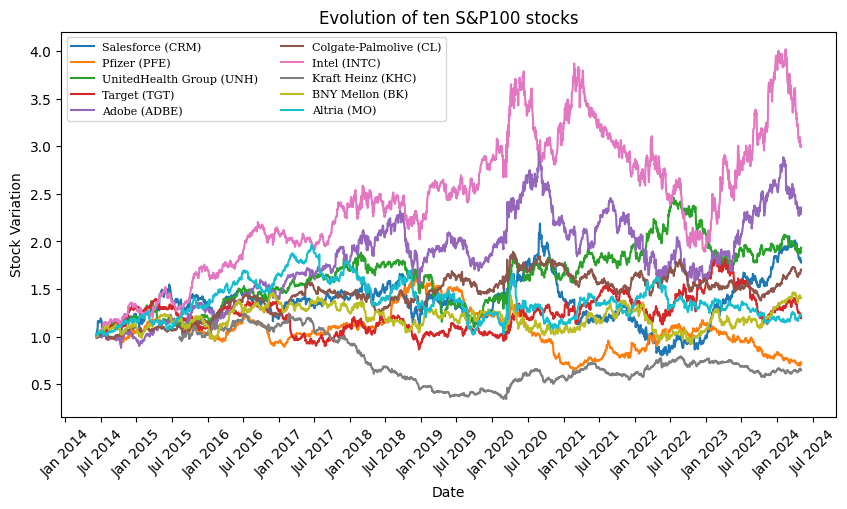

In [9]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumprod(1 + values.loc[stock]["Variation"]), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten S&P100 stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Variation')
plt.legend(ncol=2, loc="upper left", prop={'size': 8, 'family': 'serif'})
plt.show()

In [6]:
values.to_csv("../data/SP100/raw/values.csv")